## Purpose

**Fundamental goal of ML: To generalize beyond what we see in the training samples**

We often have access to only limited amount of training data, but we want to learn a mapping function which would predicts target reasonably well beyond that training data

<font color='red'>However, it's impossible to access generalization error in practice!</font>

Solution (a common way): To reduce and approximate this error by **Data Splitting**

## How?

### 80%-20% train-test split
![](imgs/train-test-split.png)

In [5]:
#| code-summary: prepare `df`
#| code-fold: true
import pandas as pd

df = pd.read_csv("data/canada_usa_cities.csv")
df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [8]:
from sklearn.model_selection import train_test_split
df_1 = df.copy()
y, X = df_1.pop("country"), df_1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [9]:
#| code-summary: alternative method (in case of performing exploratory data analysis or visualization on the `df_train`)
#| code-fold: true

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=123
)
# # or, via train_size,
# df_train, df_test = train_test_split(
#     df, train_size=0.8, random_state=123
# )

y_train, X_train = df_train.pop("country"), df_train
y_test, X_test = df_test.pop("country"), df_test

Text(0, 0.5, 'latitude')

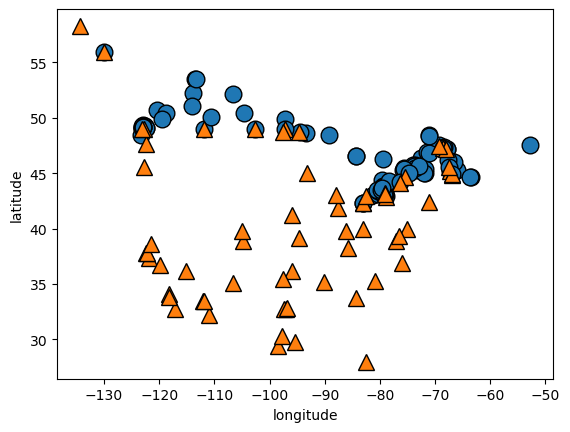

In [11]:
#| code-summary: visualize training data
#| code-fold: true
import mglearn
import matplotlib.pyplot as plt

mglearn.discrete_scatter(X_train['longitude'], X_train['latitude'], y_train, s=12)
plt.xlabel('longitude')
plt.ylabel('latitude')

In [21]:
#| code-summary: train model and calculate scores (e.g. DecisionTreeClassifier)
#| code-fold: False
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print(f"Train accuracy: {round(clf.score(X_train, y_train), 3)}")
print(f"Test accuracy: {round(clf.score(X_test, y_test), 3)}") # ~ generalization error

Train accuracy: 1.0
Test accuracy: 0.738


#### Cons

 - Approximated the generalization error, but not reduced yet.
 - We have built a perfect model on training data, but our model is not able to generalize well on the testing data!

### Train-validation-test split
 - We train our model using train split
 - And score it using validation split
 - If the score is not good, then we train another model using train split and score it again using validation split
 - Repeat the process until reaching a satisfactory score in the validation split (i.e. hyperparameter tuning)
 - Test the model once to examine the generalization
![](imgs/train-valid-test-split.png)

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # example

# data split
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=123
)
df_train, df_validation = train_test_split(
    df_train, test_size=0.25, random_state=123
)

y_train, X_train = df_train.pop("country"), df_train
y_validation, X_validation = df_validation.pop("country"), df_validation
y_test, X_test = df_test.pop("country"), df_test

# (iteratively) train model and score
for depth in range(1, 7):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    #print(f"Train accuracy (max_depth={depth}): {round(clf.score(X_train, y_train), 3)}")
    print(f"Validation accuracy (max_depth={depth}): {round(clf.score(X_validation, y_validation), 3)}")

# test model
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
print(f"Test accuracy: {round(clf.score(X_test, y_test), 3)}") # ~ generalization error

Validation accuracy (max_depth=1): 0.81
Validation accuracy (max_depth=2): 0.81
Validation accuracy (max_depth=3): 0.833
Validation accuracy (max_depth=4): 0.833
Validation accuracy (max_depth=5): 0.905
Validation accuracy (max_depth=6): 0.881
Test accuracy: 0.762


We typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

#### Pros

 - Able to reduce and approximate generalization error
 - Much better than Train-test split, in which we have only examined the training accuracy before looking at testing.

#### Cons

 - If the data set is small, then the validation set will be tiny and will not be a good representative of testing set.

### Cross-validation
 - Split the training data into k-fold
 - Each "fold" takes turn to be a validation set
 - Validation score statistics = mean/variance of each cross-validation score (scores across folds)
![](imgs/cross-validation.png)

#### training and validation

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier # example

# data split
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=123
)
y_train, X_train = df_train.pop("country"), df_train
y_test, X_test = df_test.pop("country"), df_test

# train model and score
clf = DecisionTreeClassifier(max_depth=4)

scores = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True) # is a dictionary
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002524,0.002084,0.764706,0.913333
1,0.002855,0.002135,0.823529,0.906667
2,0.001225,0.000673,0.705882,0.906667
3,0.001533,0.000713,0.941176,0.900000
4,0.000889,0.000631,0.823529,0.906667
5,0.000849,0.000594,0.823529,0.913333
6,0.001619,0.000639,0.705882,0.920000
7,0.001016,0.000566,0.937500,0.900662
8,0.000744,0.000459,0.937500,0.900662
9,0.000704,0.000463,0.937500,0.900662


In [52]:
print(f"Average cv scores: {round(scores['test_score'].mean(), 2)}")
print(f"SD of cv scores: {round(scores['test_score'].var()**0.5, 2)}")

Average cv scores: 0.84
SD of cv scores: 0.09


#### training, validation and testing

In [50]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier # example

# data split
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=123
)
y_train, X_train = df_train.pop("country"), df_train
y_test, X_test = df_test.pop("country"), df_test

# (iteratively) train model and score
for depth in range(1, 7):
    clf = DecisionTreeClassifier(max_depth=depth)
    
    scores = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True) # is a dictionary

    print(f"Average cv scores (max_depth={depth}): {round(scores['test_score'].mean(), 3)}")
    print(f"SD of cv scores (max_depth={depth}): {round(scores['test_score'].var()**0.5, 3)}\n")

# test model
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
print(f"Test accuracy: {round(clf.score(X_test, y_test), 3)}") # ~ generalization error, comparable to cv error

Average cv scores (max_depth=1): 0.81
SD of cv scores (max_depth=1): 0.085

Average cv scores (max_depth=2): 0.804
SD of cv scores (max_depth=2): 0.086

Average cv scores (max_depth=3): 0.804
SD of cv scores (max_depth=3): 0.09

Average cv scores (max_depth=4): 0.84
SD of cv scores (max_depth=4): 0.09

Average cv scores (max_depth=5): 0.846
SD of cv scores (max_depth=5): 0.083

Average cv scores (max_depth=6): 0.815
SD of cv scores (max_depth=6): 0.061

Test accuracy: 0.833


#### Pros

 - More powerful, also applied to small data set!
 - Able to examine the variation in the scores across folds
 - Give a more robust estimate of error on unseen data

## Remarks
 - We use **test error** to approximate **generalization error** (or deployment error)
 - If the test error is "reasonable", we will deploy the model
 - We typically expect $E_{\text{train}} < E_{\text{validation}} < E_{\text{test}} < E_{\text{deployment}} < E_{\text{best}}$.

### What is underfitting?
 - The model is too simple
 - Both train and validation error are similarly high
 - $E_{\text{best}} < E_{\text{train}} \lesssim E_{\text{validation}}$

### What is overfitting?
 - The model is too complicated, and specified to training data only
 - Training error is too low, and a big gap exists between training and validation error
 - $E_{\text{train}} < E_{\text{best}} < E_{\text{validation}}$

### What is *Bias vs. Variance tradeoff*?
 - A fundamental tradeoff in supervised learning
   - Complexity $\uparrow$ $\Rightarrow$ $E_\text{train} \downarrow$  **but**  $(E_\text{validation} - E_\text{train}) \uparrow$
 - **Bias $\Leftrightarrow$ Underfitting**: the tendency to consistently learn the same wrong thing
 - **Variance $\Leftrightarrow$ Overfitting**: the tendency to learn random things irrespective of real signals

![](imgs/malp_0201.png)
[source](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#relation-of-model-complexity-to-dataset-size)

### Golden rule: The test data cannot influence the training phase in any way
 - To avoid breaking it, we always keep our testing set in an imaginary vault when we're splitting data